<a target="_blank" href="https://colab.research.google.com/github/lm2612/Tutorials/blob/main/3_deeplearning/3-DeepLearning_HousePrice.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep learning: House price prediction

On Tuesday, we used linear regression to predict house prices of the [California house price dataset](https://www.kaggle.com/camnugent/california-housing-prices). Our dataset contains 200 observations for housing blocks in California obtained from the 1990 census. The dataset contains columns:

1. `longitude`: A measure of how far west a house is; a higher value is farther west

2. `latitude`: A measure of how far north a house is; a higher value is farther north

3. `housing_median_age`: Median age of a house within a block; a lower number is a newer building

4. `total_rooms`: Total number of rooms within a block

5. `total_bedrooms`: Total number of bedrooms within a block

6. `population`: Total number of people residing within a block

7. `households`: Total number of households, a group of people residing within a home unit, for a block

8. `median_income`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. `median_house_value`: Median house value for households within a block (measured in US Dollars)

10. `ocean_proximity`: Location of the house w.r.t ocean/sea

Previously, we used intuition to guess what input variables would be suitable predictors. In this example, we are going to  use all the variables available and to predict `median_house_value`.

You must be on google colab for this tutorial - otherwise you will not be able to open the dataset. First, import the needed modules, we will be using `torch` for building neural networks. On Tuesday we used a smaller subset of the full dataset. Load the file `sample_data/california_housing_train.csv`.

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

df = pd.read_csv("sample_data/california_housing_train.csv")
print(len(df))
df.head()

17000


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


Notice the dataset is much larger than Tuesday! Clean up the data and split it into training and validation. Note, we don't need to set aside test data as we will use the test data in `sample_data/california_housing_test.csv`. Remember the data is ordered, you may want to shuffle it.

In [6]:
# Remove nans
df = df.dropna()

# Shuffle the data
from sklearn.utils import shuffle
df = shuffle(df)

In [8]:
# Use 80% training, 20% validation
print(df.shape)
training = df.iloc[0:13600 :].copy()
validation = df.iloc[13601:17000 :].copy()
print(training.shape, validation.shape)

(17000, 9)
(13600, 9) (3399, 9)


Get your X and y variables. We will use all of the predictors for X and scale them to zero mean unit variance.

In [10]:
y = training["median_house_value"].values.reshape(-1, 1)
X = training[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']].values
X.shape, y.shape

((13600, 8), (13600, 1))

In [12]:
from sklearn.preprocessing import StandardScaler

# Use StandardScaler to fit and transform your variables
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

Create torch tensors ready for the neural network.

In [13]:
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)

## Build a neural network

Create a simple neural network. It can include as many or as few layers as you like. We will start simple with a 3-layer dense neural network, where we have an input layer, and 2 hidden layers with 16 nodes. For the input layer, we need to tell pytorch the number of input features (9). Then we can choose the number of hidden nodes.

In [14]:
class SimpleNet(torch.nn.Module):
    def __init__(self, n_features=8, n_targets=1):
        super().__init__()
        self.n_features = n_features
        self.n_targets = n_targets

        self.layer_input = torch.nn.Linear(self.n_features, 16)         # Input layer: n_features -> 16
        self.layer_hidden1 = torch.nn.Linear(16, 16)                    # Hidden layer 1: 16 -> 16
        self.layer_hidden2 = torch.nn.Linear(16, self.n_targets)        # Hidden layer 2: 16 -> n_targets

        self.activation_function = torch.nn.ReLU()

    def forward(self, X):
        # Input layer
        output = self.layer_input(X)
        output = self.activation_function(output)

        # Hidden layer 1
        output = self.layer_hidden1(output)
        output = self.activation_function(output)

        # Hidden layer 2
        output = self.layer_hidden2(output)
        # Notice we don't use the activation function here - why not? when would we use it?

        return output

## Check our network on one batch
Let's test our neural network on a small batch of data, before we start our training loop. Create an instance of SimpleNet and test it on a batch size of 64.

In [15]:
# Create an instance of SimpleNet
my_network = SimpleNet(n_features=8, n_targets=1)

# Get the first batch
X_batch = X[0:64, :]
y_batch = y[0:64, :]

# Test if we can call my_network without any errors
pred_batch = my_network(X_batch)

# Check the output is the correct size
print(pred_batch.shape)
assert(pred_batch.shape == y_batch.shape)

torch.Size([64, 1])


## Set up loss function and optimisation algorithms

Decide on a suitable loss function.

We will use Mean Squared Error (MSE). It is always good to check you can properly call this on your first batch of data.

In [16]:
loss_function = torch.nn.MSELoss()
loss_function(pred_batch, y_batch)

tensor(0.9050, grad_fn=<MseLossBackward0>)

Set up the optimiser and pass our network parameters to it. We will use the Adam optimiser.

In [17]:
optimiser = torch.optim.Adam(params = my_network.parameters(), lr=0.01)

## Training loop
We are ready to start our training loop. We could manually iterate through the data using indices, e.g., `X[0:64, :], y[0:64, :], ...`. But pytorch simplifies this for us with some useful functions, including mini-batching and shuffling - this will become essential when we move to large datasets. This is done in two steps, both of which are highly customisable.
First, we create a `Dataset` which contains all of our data (you can also include any relevant pre-processing functions inside the Dataset). For regression, we provide our inputs and outputs.
Then, we use a `DataLoader` that allows us to iterate through minibatches of data.

In [25]:
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset,
                                         shuffle=True,
                                         batch_size=64)

In [19]:
# Check we can iterate through the dataloader
X_batch, y_batch = next(iter(dataloader))
X_batch.shape, y_batch.shape

(torch.Size([64, 8]), torch.Size([64, 1]))

In [20]:
# creating a list with the scalr loss values for each batch
losses = []

# interating over dataloader to produce a mini-batch of inputs (X_batch) and targets (y_batch)
for X_batch, y_batch in dataloader:
    optimiser.zero_grad() # this clears the gradients from the previous batch
    pred_batch = my_network(X_batch) # this is passing the batch through my model
    loss = loss_function(pred_batch, y_batch) # computing the loss value for each batch
    loss.backward() # this is the backpropagation which computes gradients of the loss model parameters

    # Update optimiser
    optimiser.step() # uses the new gradients to update model weights and updates Adam

    # Add MSE losses to our list for plotting
    losses.append(loss.item()) # converts the scalar loss tensor to a float and appends it to the list

Plot the losses for this

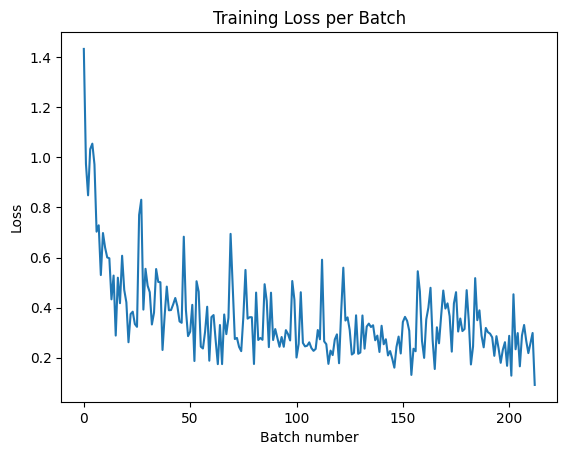

In [21]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.title("Training Loss per Batch")
plt.show()

# so figure is showing how error is reducing / plateuing batch-by-batch
# graph is noisy due to batch-by-batch variation
# can see here the model is learning because the loss is reducing - average trend is downward

## Check validation dataset
Predict using the validation dataset and compare to the true validation dataset. Check our loss function (MSE).


In [28]:
# Select your X_validation and y_validation variables.
y_validation = validation["median_house_value"].values.reshape(-1,1)
X_validation = validation[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']].values
X_validation.shape, y_validation.shape

# Scale them and create them as torch tensors (as we did for training)

X_validation_scaled = scaler_X.transform(X_validation)
y_validation_scaled = scaler_y.transform(y_validation)

X_validation = torch.tensor(X_validation_scaled, dtype=torch.float32)
y_validation = torch.tensor(y_validation_scaled, dtype=torch.float32)

# Create a torch dataset in the same way did before
from torch.utils.data import TensorDataset, DataLoader
dataset_validation = TensorDataset(X_validation, y_validation)

# And finally, create a validation dataloader with a batch size of 64 in the same way we did before
dataloader_validation = DataLoader(dataset_validation, batch_size=64, shuffle=False)

In [30]:
# Test the network on the validation dataset! Note, we need to put the network in "evaluation" mode first
my_network.eval()       # Puts network into evaluation mode
all_predicted = []
all_true = []
with torch.no_grad():
  for X_batch, y_batch in dataloader_validation:
      pred_batch = my_network(X_batch)
      all_predicted.append(pred_batch.numpy())
      all_true.append(y_batch.numpy())
all_predicted = np.vstack(all_predicted)
all_true = np.vstack(all_true)
# Check the loss
loss = loss_function(torch.tensor(all_predicted), torch.tensor(all_true))
loss
# this final value is the last loss value i.e. the loss of the pytorch data structure
# so this is MSE loss, meaning the mean squared error between the predicted validation values and true
# validation values is 0.2884 - scaled units

tensor(0.2884)

Plot the predicted against the truth

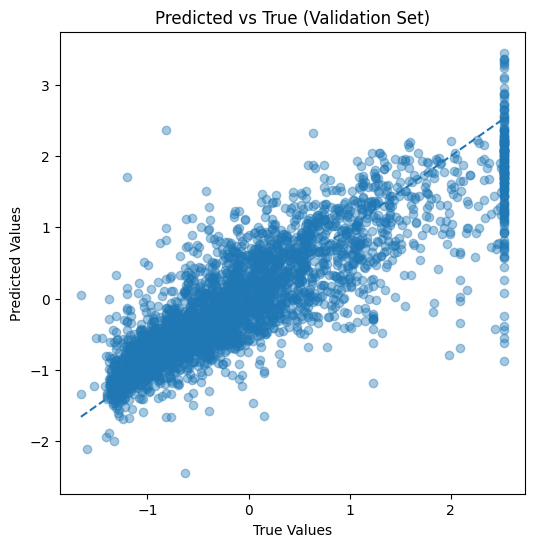

In [32]:
plt.figure(figsize=(6,6))
plt.scatter(all_true, all_predicted, alpha=0.4)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True (Validation Set)")
plt.plot([all_true.min(), all_true.max()],
         [all_true.min(), all_true.max()],
         linestyle='--')
plt.show()


How does it compare to your linear regression models on Tuesday?



In [ ]:
# far low MSE values here, like by millions lol. probably tues wasn't scaled

## Train over multiple epochs

Now you have gone through one full iteration of the data, train over multiple epochs and make sure you go through the validation dataset each epoch. Keep track of the training and validation losses averaged over each epoch separately and plot these.

In [39]:
training_losses = []
validation_losses = []
num_epochs = 100

# n/b that at this stage may want to infer the device from the model and define sizes of samples etc.
for epoch in range(num_epochs):
    # Set up training
    my_network.train()
    training_loss = 0.0

    # TRAINING LOOP
    # This will look the similar our previous single iteration
    for X_batch, y_batch in dataloader:
        optimiser.zero_grad()
        pred_batch = my_network(X_batch)
        loss = loss_function(pred_batch, y_batch)
        loss.backward()
        optimiser.step()
        training_loss += loss.item()

    # Add MSE losses to our list for plotting
    training_losses.append(training_loss)

    # Set up validation
    my_network.eval()
    validation_loss = 0.0

    # VALIDATION LOOP
    # This will look similar to your training loop, but remember you do not need to do the optimise step
    for X_batch, y_batch in dataloader_validation:
        pred_batch = my_network(X_batch)
        loss = loss_function(pred_batch, y_batch)
        validation_loss += loss.item()

    # Add MSE losses to our list for plotting
    validation_losses.append(validation_loss)

    # After every 10 epochs print mean losses
    if epoch%10 ==0:
        print(f"After epoch {epoch}: Training loss={training_loss:.2f}, validation loss={validation_loss:.2f}")

print(f"At end of training: Training loss={training_loss:.2f}, validation loss={validation_loss:.2f}")


After epoch 0: Training loss=42.50, validation loss=11.93
After epoch 10: Training loss=41.82, validation loss=12.32
After epoch 20: Training loss=41.93, validation loss=11.62
After epoch 30: Training loss=41.75, validation loss=12.41
After epoch 40: Training loss=41.45, validation loss=12.01
After epoch 50: Training loss=41.57, validation loss=11.79
After epoch 60: Training loss=41.04, validation loss=11.63
After epoch 70: Training loss=41.01, validation loss=11.47
After epoch 80: Training loss=41.28, validation loss=12.39
After epoch 90: Training loss=41.87, validation loss=12.12
At end of training: Training loss=41.03, validation loss=12.09


Check the training and validation loss curves. How do they differ?

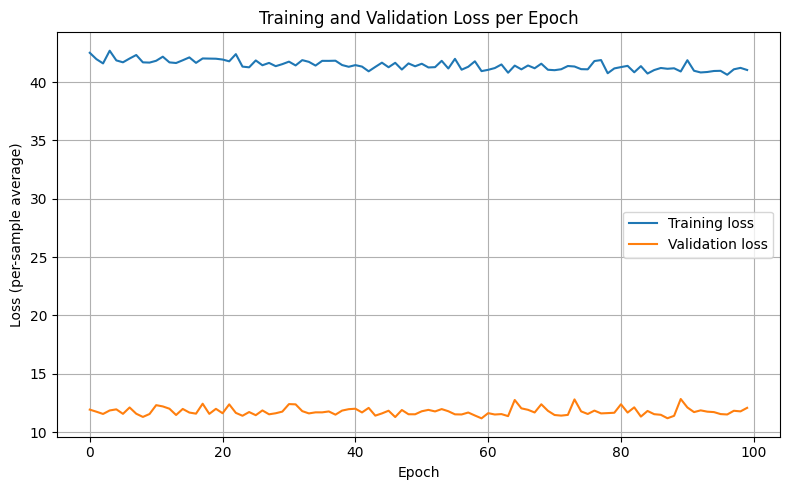

In [40]:
plt.figure(figsize=(8,5))
plt.plot(training_losses, label="Training loss")
plt.plot(validation_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (per-sample average)")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Overfitting
Keep training your network and look for signs of overfitting.

## Bonus: Exploring different choices
Play around with different versions of the network. For example, try:
* More or fewer layers.
* More of fewer hidden nodes.
* Different choice of [activation functions](https://pytorch.org/docs/main/nn.html#non-linear-activations-weighted-sum-nonlinearity)
* Different choice of [loss functions](https://pytorch.org/docs/main/nn.html#loss-functions)
* Different choice of [optimiser](https://pytorch.org/docs/main/optim.html#algorithms)

Selecting these choices for your problem is an optimisation problem in itself. This is often called hyperparameter selection. There is no best approach - usually people would manually search through some different options until we have the best results. Finding quicker methods for "hyperparameter optimisation" is a research field in itself!



### More layers
Add one layer with 32 hidden nodes and see if it you get a better performance on the validation dataset.

## Bonus: Other network parameters
Explore the following options:
* add BatchNorm
* replace the ReLU activation function with the Sigmoid activation function
* remove a hidden layer
* try a different optimisation method

## Testing
Select your best network and apply it to the test data and calculate the RMSE. Don't forget your outputs are scaled.

In [ ]:
# Open test data
testing = pd.read_csv("sample_data/california_housing_test.csv")
testing.head()

## Compare to Linear Regression
Compare your code the linear regression results you got on Tuesday. Note you will need to re-run your linear regression on this new test dataset. You may also want to re-train on this larger training dataset for a fair comparison.
